# Instance Hardness Threshold
Machine Learning with Imbalanced Data - Course

Instance hardness is the probability of an observation being miss-classified. In other words, the instance hardness is 1 minus the probability of the class. For class 1:

instance hardness = 1 - p(1)
The instance hardness depends on the algorithm used in the classification and in class separability.

# Instance Hardness Filtering
Instance Hardness filtering consists in determining the instance hardness and removing the observations that are harder to classify. That is, removing observations with high instance hardness or low class probability. The question is, how to determine the threshold.

In this notebook we will:

* Determine the instance hardness of observations
* Filter observations from the majority class based of an arbitrary threshold
* Filter observations from the majority class as proposed by Imbalanced-learn
* Use imbalance-learn to implement Instance Hardness

In this notebook we will use an example of binary classification. For multiclass classification, check the next notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict

from imblearn.under_sampling import InstanceHardnessThreshold

## Function to create data
We create a function to create data with 2 or more classes, with different class separability and imbalance ratio. The user can determine how many classes to create and how separate they are. The data will contain 2 predictive variables and 1 target with the classes.

In [2]:
def make_data(n_classes, weights, sep):
    # returns arrays
    X, y = make_classification(n_samples=1000,
                               n_features=2,
                               n_classes=n_classes,
                               n_redundant=0,
                               n_clusters_per_class=1,
                               weights=weights,
                               class_sep=sep,
                               random_state=1)
    
    # transform arrays into pandas df and series
    X = pd.DataFrame(X, columns=['varA', 'varB'])
    y = pd.Series(y)

    return X, y

## Create and plot a toy binary dataset

Target imbalance: 
0    894
1    106
Name: count, dtype: int64


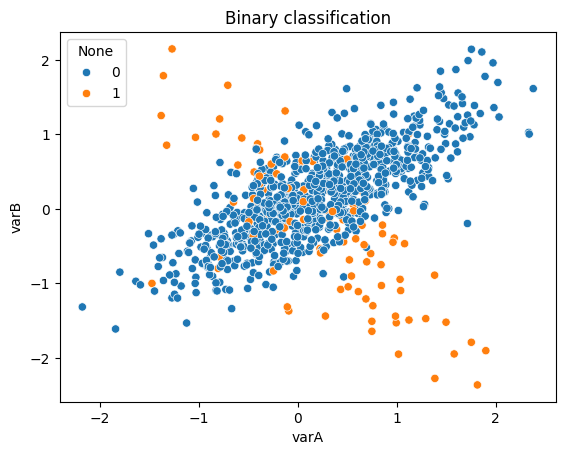

In [4]:
# binary classification -> 2 classes
X, y = make_data(n_classes=2,
                 weights=[0.90],    # imbalance 10:1
                 sep=0.2)

# print the target imbalance
print('Target imbalance: ')
print(y.value_counts())

# plot the data
sns.scatterplot(
    data=X, x='varA', y='varB', hue=y
)

plt.title('Binary classification')
plt.show()

## Train Random Forests
We will use random forests to determine instance hardness. We will do so with cross-validation, to try and perform the procedure as closely as possible to the imbalanced-learn implementation.

In [5]:
# setup a stratified cross-validation scheme
skf = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=1,
)

skf

StratifiedKFold(n_splits=3, random_state=1, shuffle=True)

In [6]:
# set up the random forests
rf = RandomForestClassifier(n_estimators=5, random_state=1, max_depth=1)

## Calculate instance hardness values

In [8]:
# obtain the predictions from the random forests
# with cross validation
probs = cross_val_predict(
    rf,
    X,
    y,
    cv=skf,
    n_jobs=-1,
    method='predict_proba',
)

probs = pd.DataFrame(probs, columns=['p(0)', 'p(1)'])

probs

,p(0),p(1)
0,0.889566,0.110434
1,0.903987,0.096013
2,0.896250,0.103750
3,0.896250,0.103750
4,0.903987,0.096013
...,...,...
995,0.889566,0.110434
996,0.889566,0.110434
997,0.848812,0.151188
998,0.889566,0.110434


The class 0 is the majority class. We want to under-sample that class. We can do so by removing observations with low p(0), which is the same as saying high instance hardness. Remember that instance hardness is 1 - the probability of the class.

## Undersample observations from the majority class

### Arbitrary threshold

In [9]:
# to pick up a threshold, let's examine the probability distributions
probs.describe()

,p(0),p(1)
count,1000.000000,1000.000000
mean,0.889839,0.110161
std,0.052598,0.052598
min,0.252222,0.060097
25%,0.889566,0.096013
50%,0.896250,0.103750
75%,0.903987,0.110434
max,0.939903,0.747778



We see that most observations of the majority class show p(0) > 0.88. We can try and remove observations under 0.85. This is arbitrary of course, we would have to try several thresholds and see what works best for our data.

In [10]:
# the 2 expressions are equivalent:
# remove obs. from majority class where instance hardness (1-p(0)) is high
# remove obs. from majority class where p(0) is low

# remove obs from the majority class only where the random forests return 
# probs below 0.85
condition = (y==0) & (probs['p(0)'] <= 0.85)

# find those observations in the dataset
filtered = X.loc[condition]

# number of observations to remove
filtered.shape

(27, 2)


Not many observations will be removed, probably because the model is doing a fair good job at classifying the classes.

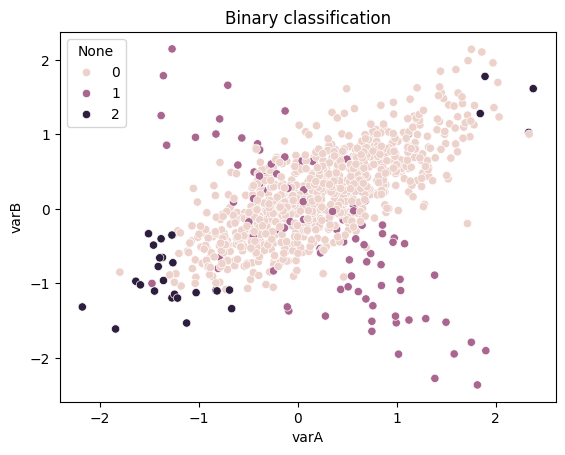

In [13]:
# let's identify which observations will be removed

# plot the data
sns.scatterplot(
    data=X, x="varA", y="varB", hue= y + 2* condition
)

plt.title('Binary classification')
plt.show()

In light pink the majority class, in dark pink the minority class, and in purple the observations from the majority that will be removed because they are the hardest to classify.

In [14]:
# drop hard instances
X_resampled = X.drop(filtered.index)
y_resampled = y.drop(filtered.index)

In [15]:
X_resampled.shape, y_resampled.shape

((973, 2), (973,))

In [16]:
# target imbalance after filtering
print('Resamped target imbalance')
print(y_resampled.value_counts())

Resamped target imbalance
0    867
1    106
Name: count, dtype: int64


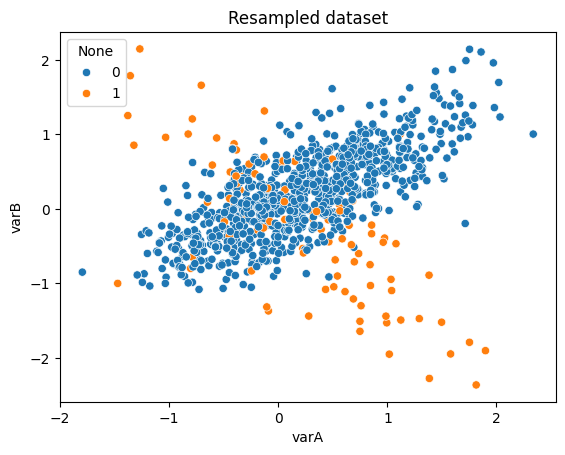

In [17]:
# plot resampled data
sns.scatterplot(data=X_resampled, x='varA', y='varB', hue=y_resampled)

plt.title('Resampled dataset')
plt.show()

The next step would be to train the model on the filtered dataset, and determine if the model produces better performance. We will do that later with a real dataset.

### Undersample data to match balancing ratio
In the following section, instead of using an arbitrary threshold, we will find a threshold that equilibrates balancing ratio.

In [19]:
# target imbalance
balance = y.value_counts()

balance

0    894
1    106
Name: count, dtype: int64

In [20]:
# balancing ratio
balance[0] / balance[1]

8.433962264150944

In [21]:
# we could arbitrarily select from the majority class the top 106 obs. as follows:
probs[y==0].sort_values(by='p(0)', ascending=False).head(106)

,p(0),p(1)
655,0.939903,0.060097
768,0.939903,0.060097
404,0.939903,0.060097
279,0.939903,0.060097
857,0.939903,0.060097
...,...,...
553,0.903987,0.096013
336,0.903987,0.096013
369,0.903987,0.096013
521,0.903987,0.096013


But, as we can see from the plot, a lot of the observations have a similar probability value, so why should we keep some and remove others?

To avoid this, imbalanced-learn determines the threshold based on the imbalance, and then selects all observations above that threshold. This is how:

In [22]:
# number of samples needed 
n_samples = 106

# total obs from majority
majority_samples = 894

# in which percentile do we find these 
# number of observations
perc = n_samples / majority_samples

perc

0.1185682326621924

In [23]:
# we want the observations with the highest p(0)
# so we are looking at the top 11% and not at the bottom 11%

# thus we need to find the top percentile which is 1 - perc

perc = (1 - perc) * 100

perc

88.14317673378076

In [24]:
# find the threshold at which we find 88% of the observations

threshold = np.percentile(probs[y == 0]['p(0)'], perc)

threshold

0.9039872125121304

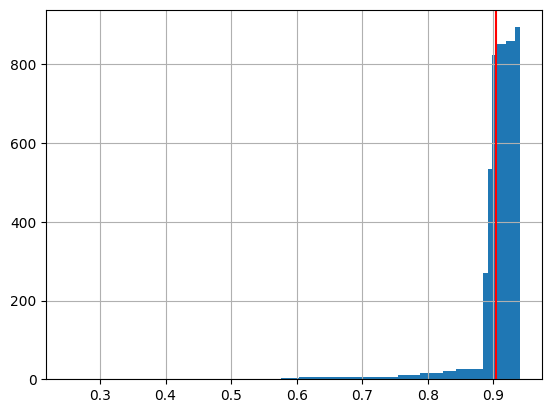

In [25]:
# to make this a bit more visual

probs[y == 0]['p(0)'].hist(cumulative=True, bins=100)
plt.axvline(x=threshold, color='red')

In [26]:
# remove observations from the majority class where the random forests return
# probs < threshold
condition = (y==0) & (probs['p(0)'] < threshold)

# find those obs in the dataset
filtered = X.loc[condition]

# number of obs to remove
filtered.shape

(534, 2)

We will remove of course a lot of observations, because we want to achieve a balanced ratio.

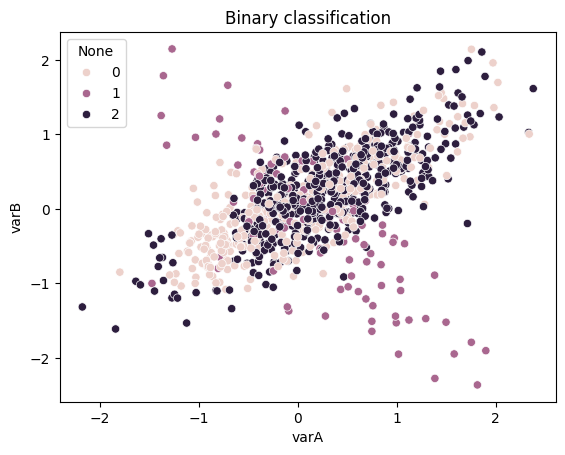

In [27]:
# let's identify which observations will be removed

# plot the data
sns.scatterplot(
    data=X, x="varA", y="varB", hue= y + 2* condition
)

plt.title('Binary classification')
plt.show()

In [28]:
# drop hard instances

X_resampled = X.drop(filtered.index)
y_resampled = y.drop(filtered.index)

X_resampled.shape, y_resampled.shape

((466, 2), (466,))

In [29]:
# print the target imabalance after filtering

print('Resampled Target imbalance: ')
print(y_resampled.value_counts())

Resampled Target imbalance: 
0    360
1    106
Name: count, dtype: int64


As we can see, we did reduce the number of observations from the majority, but we did not achieve the desired balance, because there are many observations that have a similar probability value. So this algorithm retains them all.

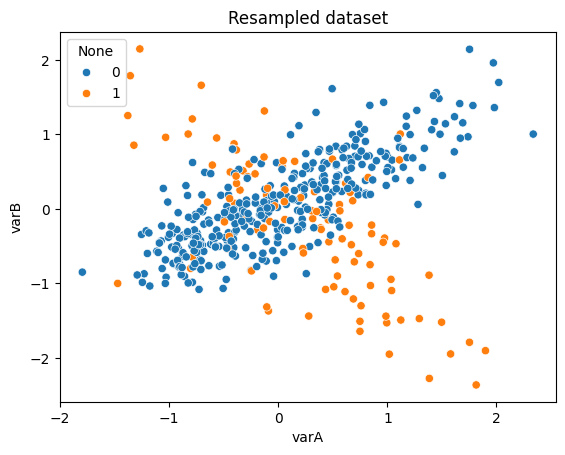

In [30]:

# finally plot resampled data

sns.scatterplot(
        data=X_resampled, x="varA", y="varB", hue=y_resampled
    )

plt.title('Resampled dataset')
plt.show()

### Instance hardness with imbalanced-learn

In [31]:
# set up instance hardness threshold
iht = InstanceHardnessThreshold(
    estimator=rf,
    sampling_strategy='auto',
    random_state=1,
    n_jobs=-1,
    cv=3,   # cross validation fold
)

X_resampled, y_resampled = iht.fit_resample(X, y)

In [32]:
# original data
X.shape, y.shape

((1000, 2), (1000,))

In [34]:
# undersampled data
X_resampled.shape, y_resampled.shape

((283, 2), (283,))

In [35]:
# balance ratio after resampling
y_resampled.value_counts()

0    177
1    106
Name: count, dtype: int64

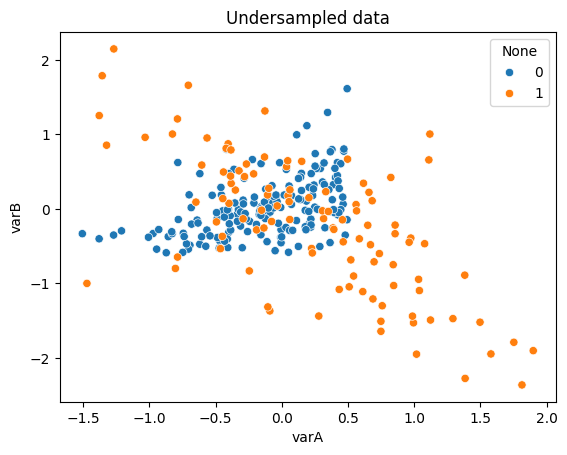

In [36]:
# plot undersampled data
sns.scatterplot(
    data=X_resampled, x='varA', y='varB', hue=y_resampled
)

plt.title('Undersampled data')
plt.show()

In [37]:
# find the removed observations
removed_obs = [0 if x in iht.sample_indices_ else 1 for x in X.index]

len(removed_obs), np.sum(removed_obs)

(1000, 717)

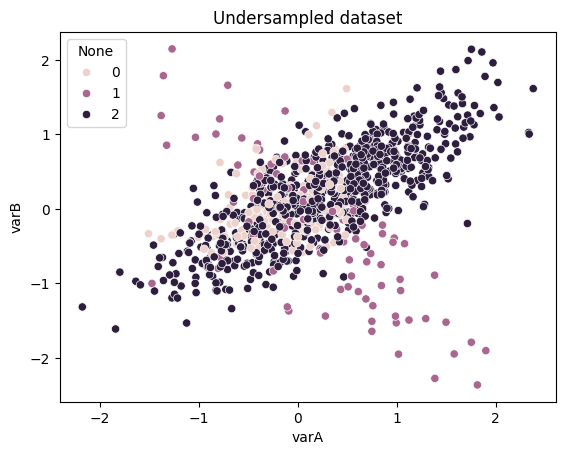

In [38]:
# plot original data highlighting removed obs
sns.scatterplot(
        data=X, x="varA", y="varB", hue= y + 2* pd.Series(removed_obs)
    )

plt.title('Undersampled dataset')
plt.show()

## Instance hardness threshold
### Real data - Performance comparison
Does it work well with real datasets?

In [39]:
# Load data
data = pd.read_csv('../datasets/kdd2004.csv')

data.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,target
0,52.0,32.69,0.30,2.5,20.0,1256.8,-0.89,0.33,11.0,-55.0,...,1595.1,-1.64,2.83,-2.0,-50.0,445.2,-0.35,0.26,0.76,-1
1,58.0,33.33,0.00,16.5,9.5,608.1,0.50,0.07,20.5,-52.5,...,762.9,0.29,0.82,-3.0,-35.0,140.3,1.16,0.39,0.73,-1
2,77.0,27.27,-0.91,6.0,58.5,1623.6,-1.40,0.02,-6.5,-48.0,...,1491.8,0.32,-1.29,0.0,-34.0,658.2,-0.76,0.26,0.24,-1
3,41.0,27.91,-0.35,3.0,46.0,1921.6,-1.36,-0.47,-32.0,-51.5,...,2047.7,-0.98,1.53,0.0,-49.0,554.2,-0.83,0.39,0.73,-1
4,50.0,28.00,-1.32,-9.0,12.0,464.8,0.88,0.19,8.0,-51.5,...,479.5,0.68,-0.59,2.0,-36.0,-6.9,2.02,0.14,-0.23,-1


In [40]:
# imbalanced target
data['target'].value_counts(normalize=True)

target
-1    0.991108
 1    0.008892
Name: proportion, dtype: float64

In [41]:
# separate dataset into train and test

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),  # drop the target
    data['target'],  # just the target
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((102025, 74), (43726, 74))

In [42]:
# set up the models we want to compare
# remember that we should calculate instance hardness 
# with the same models we intend to train as final model
logit = LogisticRegression(random_state=0, max_iter=1000)

rf = RandomForestClassifier(n_estimators=100, random_state=39, max_depth=2)

In [43]:
# resample using instance hardness threshold with logistic regression
iht_logit = InstanceHardnessThreshold(
    estimator=logit,
    sampling_strategy='auto',
    random_state=0,
    n_jobs=-1,
    cv=3,
)

X_logit, y_logit = iht_logit.fit_resample(X_train, y_train)

In [44]:
# resample using instance hardness threshold with random forests
iht_rf = InstanceHardnessThreshold(
    estimator=rf,
    sampling_strategy='auto',
    random_state=0,
    n_jobs=-1,
    cv=3,
)

X_rf, y_rf = iht_rf.fit_resample(X_train, y_train)

In [45]:
# compare shapes of original and resampled datasets
X_train.shape, X_logit.shape, X_rf.shape

((102025, 74), (1782, 74), (1782, 74))

## Machine learning performance comparison

In [46]:
# function to train random forests and evaluate the performance
def run_randomForests(X_train, X_test, y_train, y_test):
    
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [48]:
# function to train logistic regression and evaluate the model performance
def run_logit(X_train, X_test, y_train, y_test):
    
    model = logit
    model.fit(X_train, y_train)

    print('Train set')
    pred = model.predict_proba(X_train)
    print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = model.predict_proba(X_test)
    print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

### Random Forests comparison

In [47]:
# evaluate performance of algorithm built
# using imbalanced dataset
run_randomForests(X_train, X_test, y_train, y_test)

Train set
Random Forests roc-auc: 0.9736769545142595
Test set
Random Forests roc-auc: 0.9724711107235364


In [49]:
# evaluate performance of the same algorithm but now trained
# using the resampled data with iht with random forests

run_randomForests(X_rf,
                  X_test,
                  y_rf,
                  y_test)

Train set
Random Forests roc-auc: 0.9710687118094526
Test set
Random Forests roc-auc: 0.9670932553168265


### Logistic regression comparison

In [50]:
# evaluate performance of algorithm built
# using imbalanced dataset
run_logit(X_train, X_test, y_train, y_test)

Train set
Logistic Regression roc-auc: 0.9913076953142609
Test set
Logistic Regression roc-auc: 0.9905616441830596


c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [51]:
# evaluate performance of the same algorithm but now trained
# using the resampled data with iht with logistic regression

run_logit(X_logit,
          X_test,
          y_logit,
          y_test)

Train set
Logistic Regression roc-auc: 0.8892302498737217
Test set
Logistic Regression roc-auc: 0.9442113866596219


c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
